In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df, equalize_len_trace
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

### Experiment: Equal Trace Lengths (10,000) - Regression

- Result: Test R^2: -0.0208

# Load and Clean Data

Data is stored in csv files. A data frame is created with the values:
- Trace - Shortened trace to be used as model input (ex. 1400 points before start of breathold, 100 points after start of breathhold)
- Csv_breath_holds - Breath hold length listed in CSV file
- Data_breath_holds - Breath hold length found using the derivative of the full trace
- Full_trace - Complete breath trace data (given in CSV file)
- breathhold_idx - Indices of the full trace identified as breathhold due to the derivative being zero
- bh_start_end - Indices of the full trace where the breathhold starts and ends (based on breathhold_idx)

In [3]:
beforeBH_len = 1400
afterBH_len = 100
trace_len = beforeBH_len+afterBH_len

In [4]:
# breath_df = get_breath_df('data_sdx_', 1400, 100, True)
# breath_df.to_pickle('breath_pickle')

In [5]:
breath_df = pd.read_pickle('breath_pickle')

In [6]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]
under2 = under2.reset_index(drop=True)

In [7]:
trace_lens = [len(row) for row in under2['Trace']]

In [8]:
print('Average trace len:', np.mean(trace_lens), '\t75th Percentile:', np.percentile(trace_lens, 75), '\tMax trace len:',max(trace_lens))

Average trace len: 5751.174911292006 	75th Percentile: 6312.5 	Max trace len: 24720


**Discrepancies:** Only considering files where the breathhold length listed in the CSV files is within 2 seconds of the breathhold length identified using the derivative of the trace to avoid using innacurate breath hold indices.

In [9]:
q25 = under2['Data_breath_holds'].quantile(.10)
q75 = under2['Data_breath_holds'].quantile(.90)

In [10]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

# Split and Normalize Data

In [11]:
df = under2

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['Data_breath_holds'], test_size=0.20)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2)

In [14]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [15]:
x_train2, x_val2 = normalize(x_train, x_val)

In [16]:
x_train2, x_test2 = normalize(x_train, x_test)

# Equalize Lengths

In [17]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [18]:
def equalize_lengths(df, trim_len):
    equal_traces = []
    for i in range(len(df)):
        curve = df[i]
        if len(curve) > trim_len:
            start_idx = len(curve)-trim_len
            equal_traces.append(curve[start_idx:])
        elif len(curve) < trim_len:
            num_zeros = trim_len - len(curve)
            
            random_nums = (np.random.random_sample(num_zeros)-0.5)
            box_pts = 100
            box = np.ones(box_pts)/box_pts
            random_nums = np.convolve(random_nums, box, mode = 'same')
            random_nums = random_nums[:num_zeros]
            #zeros = np.zeros([1, num_zeros])[0]
            equal_traces.append(np.concatenate((random_nums, curve)))
        else:
            equal_traces.append(curve)
 
    return np.array(equal_traces)

In [19]:
x_train3 = equalize_lengths(x_train2, 10000)
x_val3 = equalize_lengths(x_val2, 10000)
x_test3 = equalize_lengths(x_test2, 10000)

# Initialize Data for Model and Create DataLoader

In [20]:
#dataset
from torch.utils.data import Dataset

In [21]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [22]:
dataset = timeseries(x_train3,y_train)
valid_dataset = timeseries(x_val3,y_val)
test_dataset = timeseries(x_test3,y_test)

In [23]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=300)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=300)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=300)

In [24]:
print("Training Shape", dataset.x.shape, dataset.y.shape)

Training Shape torch.Size([610, 10000]) torch.Size([610])


# Define LSTM Model 

In [25]:
class myLSTM_Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=15, num_layers=1):
        super(myLSTM_Model,self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
    
    def forward(self, x):
        out_pack, (ht, ct) = self.lstm(x)
        output = self.linear(ht[-1])
        return output
        

model = myLSTM_Model() 

In [26]:
print(model)

myLSTM_Model(
  (lstm): LSTM(1, 15, batch_first=True)
  (linear): Linear(in_features=15, out_features=1, bias=True)
)


In [27]:
# Initialize History
history = []

In [32]:
# Declaring Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
epochs = 25

## Training Loop

 Try predicting breathhold values
 Smaller training/simple case
 Simulated data (have amplitude be the same, only change length of breathhold)

In [33]:
trace_len = len(x_train3[0])

In [34]:
criterion = torch.nn.MSELoss()

In [ ]:
for i in range(epochs):
    
    # Training Loss
    train_loss = 0.0
    train_preds = []
    model.train()
    for x, y in train_loader:  
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1)) 
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        train_loss += loss.item()
        train_preds.append(ypred)
    
    # Validation Loss
    valid_loss = 0.0
    val_preds = []
    model.eval()
    for x, y in val_loader:
        # Forward Pass
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1)) 
        valid_loss += loss.item()
        val_preds.append(ypred)
    
    if i%5 == 0:
        torch.save(model, 'lstm_bh')
        
    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    print(f'Epoch {i+1} \t Training MSE: {train_loss/len(train_loader)} \tValidation MSE: {valid_loss/len(val_loader)}')


Epoch 1 	 Training MSE: 464.4722493489583 	Validation MSE: 423.7464904785156
Epoch 2 	 Training MSE: 408.82525634765625 	Validation MSE: 423.4798583984375
Epoch 3 	 Training MSE: 496.3388264973958 	Validation MSE: 423.2076721191406
Epoch 4 	 Training MSE: 477.7791035970052 	Validation MSE: 423.0764465332031
Epoch 5 	 Training MSE: 487.2685241699219 	Validation MSE: 422.951171875
Epoch 6 	 Training MSE: 431.10813395182294 	Validation MSE: 422.86865234375
Epoch 7 	 Training MSE: 480.63035074869794 	Validation MSE: 422.8438720703125
Epoch 8 	 Training MSE: 461.18201700846356 	Validation MSE: 422.8438415527344
Epoch 9 	 Training MSE: 478.04014078776044 	Validation MSE: 422.8359680175781
Epoch 10 	 Training MSE: 434.1622009277344 	Validation MSE: 422.8174133300781
Epoch 11 	 Training MSE: 435.61474609375 	Validation MSE: 422.77020263671875
Epoch 12 	 Training MSE: 435.78411865234375 	Validation MSE: 422.66070556640625
Epoch 13 	 Training MSE: 404.5907796223958 	Validation MSE: 422.411071777

In [36]:
torch.save(model, 'lstm_bh')

## Plot Loss

In [1]:
history = torch.tensor(history)

NameError: name 'torch' is not defined

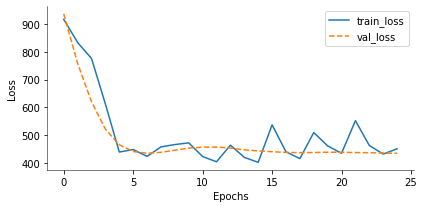

In [38]:
plot_loss(history, maxy = 50)

In [39]:
#test set actual vs predicted
test_set = timeseries(x_test3,y_test)

In [40]:
test_pred = model(test_set[:][0][0:50].view(-1,10000,1)).view(-1)

In [42]:
testloss = torch.nn.MSELoss()(test_pred.view(-1,1),test_set.y[0:50].view(-1,1))
print("Testing loss: ", testloss.detach().numpy())

Testing loss:  458.77103


In [50]:
from sklearn.metrics import r2_score
r2 = r2_score(test_set.y[0:50].detach().numpy(), test_pred.detach().numpy())
print("Test R^2:", r2)

Test R^2: -0.020795656947656838
